# **LSTM**

전에 배웟으니 생략하겠습니다.

> **오늘의 목표**

LSTM을 이용하여 텍스트를 생성해봅시다.

In [1]:
import pandas as pd
import numpy as np
from string import punctuation

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

from google.colab import files
f = files.upload()

import io

df = pd.read_csv(io.BytesIO(f['ArticlesApril2018.csv']))
df.head()

Saving ArticlesApril2018.csv to ArticlesApril2018.csv


,articleID,articleWordCount,byline,documentType,headline,keywords,multimedia,newDesk,printPage,pubDate,sectionName,snippet,source,typeOfMaterial,webURL
0,5adf6684068401528a2aa69b,781,By JOHN BRANCH,article,Former N.F.L. Cheerleaders’ Settlement Offer: ...,"['Workplace Hazards and Violations', 'Football...",68,Sports,0,2018-04-24 17:16:49,Pro Football,"“I understand that they could meet with us, pa...",The New York Times,News,https://www.nytimes.com/2018/04/24/sports/foot...
1,5adf653f068401528a2aa697,656,By LISA FRIEDMAN,article,E.P.A. to Unveil a New Rule. Its Effect: Less ...,"['Environmental Protection Agency', 'Pruitt, S...",68,Climate,0,2018-04-24 17:11:21,Unknown,The agency plans to publish a new regulation T...,The New York Times,News,https://www.nytimes.com/2018/04/24/climate/epa...
2,5adf4626068401528a2aa628,2427,By PETE WELLS,article,"The New Noma, Explained","['Restaurants', 'Noma (Copenhagen, Restaurant)...",66,Dining,0,2018-04-24 14:58:44,Unknown,What’s it like to eat at the second incarnatio...,The New York Times,News,https://www.nytimes.com/2018/04/24/dining/noma...
3,5adf40d2068401528a2aa619,626,By JULIE HIRSCHFELD DAVIS and PETER BAKER,article,Unknown,"['Macron, Emmanuel (1977- )', 'Trump, Donald J...",68,Washington,0,2018-04-24 14:35:57,Europe,President Trump welcomed President Emmanuel Ma...,The New York Times,News,https://www.nytimes.com/2018/04/24/world/europ...
4,5adf3d64068401528a2aa60f,815,By IAN AUSTEN and DAN BILEFSKY,article,Unknown,"['Toronto, Ontario, Attack (April, 2018)', 'Mu...",68,Foreign,0,2018-04-24 14:21:21,Canada,"Alek Minassian, 25, a resident of Toronto’s Ri...",The New York Times,News,https://www.nytimes.com/2018/04/24/world/canad...


> 훈련 데이터 전처리

저희는 'headline' 열에 해당하는 데이터만 사용합니다.

```
print('열의 개수: ',len(df.columns))
print(df.columns)

# 이와 같이 열의 개수를 알아낼 수 있습니다.
```



In [2]:
# 빈 데이터가 있는지 확인합니다 (중요)

print(df['headline'].isnull().values.any())

False


In [3]:
# 신문기사의 제목을 뽑아 리스트로 만듭니다.
headline = []

# 헤드라인의 값들을 리스트로 저장
headline.extend(list(df.headline.values))

print('총 샘플의 개수 : {}'.format(len(headline)))

#Unknown 데이터는 제거합시다
headline = [word for word in headline if word != "Unknown"]
print('노이즈값 제거 후 샘플의 개수 : {}'.format(len(headline)))

headline[:5]

총 샘플의 개수 : 1324
노이즈값 제거 후 샘플의 개수 : 1214


['Former N.F.L. Cheerleaders’ Settlement Offer: $1 and a Meeting With Goodell',
 'E.P.A. to Unveil a New Rule. Its Effect: Less Science in Policymaking.',
 'The New Noma, Explained',
 'How a Bag of Texas Dirt  Became a Times Tradition',
 'Is School a Place for Self-Expression?']

In [4]:
# 데이터 전처리를 합니다. 여기서는 구두점 제거 및 단어의 소문자화를 진행합니다.

def repreprocessing(raw_sentence):
    preproceseed_sentence = raw_sentence.encode("utf8").decode("ascii",'ignore')
    # 구두점 제거와 동시에 소문자화
    return ''.join(word for word in preproceseed_sentence if word not in punctuation).lower()

preprocessed_headline = [repreprocessing(x) for x in headline]
preprocessed_headline[:5]

['former nfl cheerleaders settlement offer 1 and a meeting with goodell',
 'epa to unveil a new rule its effect less science in policymaking',
 'the new noma explained',
 'how a bag of texas dirt  became a times tradition',
 'is school a place for selfexpression']

In [5]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(preprocessed_headline)
vocab_size = len(tokenizer.word_index) + 1
print('단어 집합의 크기 : %d' % vocab_size)

단어 집합의 크기 : 3494


In [6]:
# 샘플에 대한 정수 인코딩을 합니다.

sequences = list()

for sentence in preprocessed_headline:

    # 각 샘플에 대한 정수 인코딩
    encoded = tokenizer.texts_to_sequences([sentence])[0] 
    for i in range(1, len(encoded)):
        sequence = encoded[:i+1]
        sequences.append(sequence)

sequences[:11]

[[99, 269],
 [99, 269, 371],
 [99, 269, 371, 1115],
 [99, 269, 371, 1115, 582],
 [99, 269, 371, 1115, 582, 52],
 [99, 269, 371, 1115, 582, 52, 7],
 [99, 269, 371, 1115, 582, 52, 7, 2],
 [99, 269, 371, 1115, 582, 52, 7, 2, 372],
 [99, 269, 371, 1115, 582, 52, 7, 2, 372, 10],
 [99, 269, 371, 1115, 582, 52, 7, 2, 372, 10, 1116],
 [100, 3]]

> 왜 저렇게 전처리하나요

**경마장에 있는 말이 뛰고 있다** 라는 문장을 보면 <br>
최종적으로 원하는 훈련 데이터는 하나의 단어를 예측하기 위해 이전에 등장한 단어를 참고해야 하기 때문입니다.

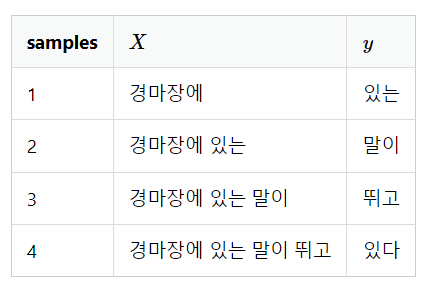

In [7]:
# 어떤 정수가 어떤 단어를 의미하는지 알아봅시다

index_to_word = {}
for key, value in tokenizer.word_index.items(): # 인덱스를 단어로 바꾸기 위해 index_to_word를 생성
    index_to_word[value] = key

print('빈도수 상위 582번 단어 : {}'.format(index_to_word[582]))

빈도수 상위 582번 단어 : offer


In [8]:
max_len = max(len(l) for l in sequences)
print('샘플의 최대 길이 : {}'.format(max_len))

print()
print()

# 샘플을 패딩합니다
sequences = pad_sequences(sequences, maxlen=max_len, padding='pre')
print(sequences[:3])

print()
print()

sequences = np.array(sequences)
X = sequences[:,:-1]
y = sequences[:,-1]
print(X[:3])
print()
print()
print(y[:3])

샘플의 최대 길이 : 24


[[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0   99  269]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0   99  269  371]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0   99  269  371 1115]]


[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0  99]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0  99 269]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0  99 269 371]]


[ 269  371 1115]


위에서 나온 표와 비슷한 모양새입니다.

> **모델 설계하기**

LSTM을 이용하여 설계합니다.

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, LSTM

embedding_dim = 10
hidden_units = 128

y = to_categorical(y, 3494)

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(LSTM(hidden_units))
model.add(Dense(vocab_size, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X, y, epochs=200, verbose=1)



Epoch 1/200
244/244 [==============================] - 14s 45ms/step - loss: 7.6307 - accuracy: 0.0290
Epoch 2/200
244/244 [==============================] - 11s 45ms/step - loss: 7.1033 - accuracy: 0.0286
Epoch 3/200
244/244 [==============================] - 11s 44ms/step - loss: 6.9666 - accuracy: 0.0342
Epoch 4/200
244/244 [==============================] - 10s 41ms/step - loss: 6.8321 - accuracy: 0.0434
Epoch 5/200
244/244 [==============================] - 11s 46ms/step - loss: 6.6638 - accuracy: 0.0481
Epoch 6/200
244/244 [==============================] - 12s 49ms/step - loss: 6.4690 - accuracy: 0.0497
Epoch 7/200
244/244 [==============================] - 11s 46ms/step - loss: 6.2613 - accuracy: 0.0551
Epoch 8/200
244/244 [==============================] - 11s 47ms/step - loss: 6.0520 - accuracy: 0.0601
Epoch 9/200
244/244 [==============================] - 11s 46ms/step - loss: 5.8509 - accuracy: 0.0692
Epoch 10/200
244/244 [==============================] - 11s 46ms/step - l

In [10]:
def sentence_generation(model, tokenizer, current_word, n): # 모델, 토크나이저, 현재 단어, 반복할 횟수
    init_word = current_word
    sentence = ''

    # n번 반복
    for _ in range(n):
        encoded = tokenizer.texts_to_sequences([current_word])[0]
        encoded = pad_sequences([encoded], maxlen=max_len-1, padding='pre')

        # 입력한 X(현재 단어)에 대해서 y를 예측하고 y(예측한 단어)를 result에 저장.
        result = model.predict(encoded, verbose=0)
        result = np.argmax(result, axis=1)

        for word, index in tokenizer.word_index.items(): 
            # 만약 예측한 단어와 인덱스와 동일한 단어가 있다면
            if index == result:
                break

        # 현재 단어 + ' ' + 예측 단어를 현재 단어로 변경
        current_word = current_word + ' '  + word

        # 예측 단어를 문장에 저장
        sentence = sentence + ' ' + word

    sentence = init_word + sentence
    return sentence


In [14]:
# 임의의 단어에 대해 10개의 단어를 추가 생성해봅시다.
print(sentence_generation(model, tokenizer, 'We', 10))

We were ready to give up on a second baby until
